# **Women in Bioinformatics and Data Science**

## <font color=purple>**2023 1st WBDS LA Camp "Introduction to Bioinformatics and Data Science"** 
## Proyecto final elaborado por Norma Paulina López Zamora para el Bootcamp "Women in bioinformatics and Data Science"

## Introducción

Los fitopatógenos tienen un impacto importante tanto en el aspecto ambiental como económico, pues afectan la producción agricola y forestal (Bergeret, 2017). Dichos efectos han cobrado mayor impocta debido a cambio climatico,  la aparición de nuevas enfermedades así como a la rápida propagación de las mismas (Chakraborty  y Newton, 2011).
Actualmente se ha visto una reducción del uso de pesticidas convencionales y ha aumentado el interés por alternativas que sean sostenibles y eficaces (Lamichhane, et al. 2016).
El control biológico se considera una  buena alternativa y en las últimas décadas se ha desarrollado una amplia gama de agentes de biocontrol microbiano (BCA) para el manejo de enfermedades fúngicas y bacterianas. Los agentes biólogicos que más se han estudiado son bacterias pertenecientes al género Pseudomonas spp., Bacillus spp. y Streptomyces spp., que ya han sido registradas como productos comerciales y comercializadas (Bonaterra, et al. 2022)

El presente trabajo tiene como objetivo buscar secuencias codificantes de proteínas asociadas a la sintesis de compuestos antimicrobianos. De manera global, el poryecto abarca los siguiente rubros:

-  Predicción de genes en genomas bacterianos
-  Búsqueda de secuencias proteínicas en bases de datos
-  Búsqueda de secuencias homólogas usando BLAST
-  Búsqueda de dominios funcionales en proteínas seleccionadas 

Para llevar a cabo lo anterior, se eligió trabajar con uno de los géneros bacterianos más estudiados en el control biológico: *Pseudomonas*

Referencias consultadas:

- Bergeret, P. (2017). The future of food and agriculture: Trends and challenges [Note de lecture]. Bibliographie prospective, n. 29/09, 3.
- Bonaterra A, Badosa E, Daranas N, Francés J, Roselló G, Montesinos E. Bacteria as Biological Control Agents of Plant Diseases. (2022).Microorganisms.  31;10(9):1759. doi: 10.3390/microorganisms10091759
- Chakraborty, S., and Newton, A. C. (2011). Climate change, plant diseases and food security: an overview. Plant pathology, 60(1), 2-14.
- Lamichhane, J. R., Dachbrodt-Saaydeh, S., Kudsk, P., and Messéan, A. (2016). Toward a reduced reliance on conventional pesticides in European agriculture. Plant Disease, 100(1), 10-24.







# **0. Preparación del entorno**

>1.  ### Para que el notebook funcione adecuadamente se debe contrar con correo electrónico y la API key que proporciona NCBI a sus usuarios registrados
>2. ### Se hará uso de las siguientes bibliotecas, que se pueden instalar con el comando !pip3 install

In [7]:
!pip3 install matplotlib
!pip3 install requests
!pip3 install matplotlib
!pip3 install pandas
!pip3 install pycirclize
!pip3 install pyrodigal
!pip3 install requests
!pip3 install seaborn
!pip3 install biopython


#Las bibliotecas `sys`,`subprocess` y `io` forman parte del core de python

## Las bibliotecas que usaremos son las siguientes:


- ### [pandas](https://pandas.pydata.org/) para el manejo general de datos
- ### [pyCirclize](https://moshi4.github.io/pyCirclize/) para visualizar nuestros datos genómicos
- ### [pyrodigal](https://pyrodigal.readthedocs.io/en/stable/) para la predicción de genes codificantes
- ### [requests](https://requests.readthedocs.io/en/latest/) para interactuar con las APIs de NCBI, UniProt 
- ### [seaborn](https://seaborn.pydata.org/) para visualizar algunas de las propiedades genómicas obtenidas
- ### [subprocess](https://docs.python.org/3/library/subprocess.html) ejecutar comandos fuera del entorno de python
- ### [BioPython](https://biopython.org/) para el manejo de secuencias
- ### [io](https://docs.python.org/3/library/io.html) para conectar las entradas y salidas de los distintos programas

## Importemos las librerías que vamos a usar con el siguiente código:

In [8]:

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from Bio import Entrez
Entrez.email   = "paulyna_9omar@hotmail.com"
Entrez.api_key = "48c3a23c85df17cbf0c11dae486cf7723b09"
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry


# **1. Obtención de una secuencia genómica**
## Ejemplo: *Pseudomonas*

## A la fecha, se ha caracterizado gran diversidad de géneros bacterianos que tiene la capacidad de fijar nitrogeno y producir compuestos que estimulan el crecimiento vegetal. El género *Pseudomonas* ha sido ampliamente estudiado por su capacidad de excretar metabolitos secundarios que han demostrado ser efectvios en el biocontrol (Bonaterra, et al. 2022). 


### En el sitio web de [NCBI - Genome](https://www.ncbi.nlm.nih.gov/data-hub/genome) se realizó una búsqueda del genero *Pseudomonas*

- #### Para este trabajo se usó el  ensamble [ASM1340352v1](https://www.ncbi.nlm.nih.gov/labs/data-hub/genome/GCA_013403525.1/), y buscarán genes de producción de metabolitos secuendarios (antimicrobianos) para uso en biocontrol  en el cromosoma con número de acceso [CP058636.1](https://www.ncbi.nlm.nih.gov/nuccore/CP058636.1)

### El genoma elegido tiene un status de "completo" y no tiene anotaciones genómicas. Con el siguiente código descargamos el genoma de *Pseudomonas* sp DS1


In [9]:
accession = "CP058636.1" #descargaremos la sedecuencia en formato "gb"
genome = Entrez.efetch(db="nucleotide",
                       id=accession,
                       format="gb",
                       rettype="text")
record = SeqIO.read(genome, "genbank")
genome_length = len(record.seq)

In [10]:
#llamaos a la variable para verificar que la variable contiene la longitud del genoma de interés
genome_length

1198745

# **2. Predicción de genes usando pyrodigal**


## Emplearemos pyrodigal para buscar genes en genomas bacterianos

### Con el siguiente código podemos encontrar los genes codificantes de proteínas en nuestro genoma procariótico de *Pseudomonas* sp DS1

In [11]:
orf_finder = pyrodigal.OrfFinder()#llamamos pyrodigal.orFinder para entrenar la funcion con la secuencia elegida
orf_finder.train(bytes(record.seq)) 
orf_genes  = orf_finder.find_genes(bytes(record.seq))#find genes para encontrar los genes en la secuencia genomica de Pseudomonas


### Con el siguiente código, almacenaremos las secuencias aminoacídicas de los genes predichos en un archivo`CP058636.1.faa`
### (archivo fasta de aminoacidos) 

> ### Para identificar nuestras secuencias aminoacídicas usaremos el prefijo PseudoDS1

In [20]:
aa_file = accession + ".faa"
prefix  = "PseudoDS1"
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)

In [21]:
! type CP058636.1.faa #podemos llamar al archivo para ver su información con este código

^C
>PseudoDS1_1 # 3513 # 3722 # 1 # ID=1_1;partial=00;start_type=ATG;rbs_motif=GGAG/GAGG;rbs_spacer=5-10bp;gc_cont=0.538
MSSIKEVIQPQVPLRLPCYDFTPVMNHTVVTVLPKVRLATSGATHSHGVTGGVYKARERI
HRDILIHDY*
>PseudoDS1_2 # 5642 # 6862 # -1 # ID=1_2;partial=00;start_type=ATG;rbs_motif=AGGAG;rbs_spacer=5-10bp;gc_cont=0.591
MGALSHLRVLDLSRVLAGPWAGQILADLGAEVIKVERPGNGDDTRAWGPPFLKDAYGENT
SEAAYYLSANRNKQSVTIDFTRPEGQKLVRELALKSDILIENFKVGGLAAYGLDYESLRA
INPNLIYCSITGFGQTGPYAKRAGYDFMIQGLGGLMSLTGRPEGDEGAGPVKVGVALTDI
LTGLYSTVAILAALAHRDHDGGGQHIDMALLDVQVACLANQAMNYLTTGNAPKRLGNAHP
NIVPYQDFPTADGDFILTVGNDGQFRKFAEVAGQPQWADDPRFATNKLRVANRAVLIPLI
RQATVFKTTAEWVAQLEQAGVPCGPINDLSQVFEDPQVKARGLAIELPHALAGMVPQVAS
PIRMSQTPVEYRRAPPLLGEHTLDVLQRVLGMGVGAVADLKAAGVL*
>PseudoDS1_3 # 6876 # 8057 # -1 # ID=1_3;partial=00;start_type=ATG;rbs_motif=GGAG/GAGG;rbs_spacer=5-10bp;gc_cont=0.580
MGGKASFNWIDPLLLDQQLTEEERMIRDTAEQFAQQSLAPRVLEAFRHEKTDPAIFREMG
EVGLLGATIPEQYGGSGLNYVSYGLIAREVERVDSGYRSMMSVQSSLVMVPINEFGTEAQ
KQKYLPKLASGEWIGCFGLTEPNHGSDPGAMITRARK


CP058636.1.faa


El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: #podemos.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: llamar.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: al.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: archivo.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: para.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: ver.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: su.
El sistema no puede encontrar el archivo especificado.
Error mientras se procesaba: informaci�n.



>PseudoDS1_282 # 326364 # 326789 # 1 # ID=1_282;partial=00;start_type=ATG;rbs_motif=GGA/GAG/AGG;rbs_spacer=5-10bp;gc_cont=0.563
MLSRAQLSFFMAALWWPLLAVLAISSYDLWNGEYSTPESSGIYWQYLLWWGIPGLLGFSL
WMSRSAQSRNEQQALRMVWWAPVKFIPFYAVPWMLYGLLSLAVGQLSDAYMAYGWISIVP
FLLIGGYVCAGVTVALYRIFF*
>PseudoDS1_283 # 326817 # 328604 # 1 # ID=1_283;partial=00;start_type=GTG;rbs_motif=GGA/GAG/AGG;rbs_spacer=5-10bp;gc_cont=0.601
MSFNHYYQSELTALRQLGRRFAERSPALAPYLGQAGRDPDVERLLEGFAFLTGRLRQKLD
DELPELSHSLMQLLWPNYMRPLPAFSILQFDPLKRSGPALRVERDTPIESKPIEDVRCRF
RTCYPTDVLPLDLAALNYSVKGDGSLLSLRLEMSADGHLGELELSKLRLHFAGERYISQM
LYLSLLRNLEGIELIPLDGAGKPIDGVSGKPMAFKIPGDRVKPVGFAEEEALIPYPLNTF
RGYRYLQEYFAFQDKFLFVDVNGLDIINALPEDTLKQMRGLELRFDIRKSGIMRMRPTLD
NVKLFCTPIANLFAHDALPIRLDGKQDEYLLLPAEYDLENCGVFSVETVTGWKPGGLGYQ
EYVPFESFEHDPSFDVPNSRPHYSIRQRSSLLHDGLDTYLSFGIRHTEAHETLSIELICT
NQNLPRKLKLGDICMACEETPEFLSFRNITPATSSFAPPLNRDFLWKLISNMSLNYLSLA
DVNALKVILETYDLPRYYDQHAEKVSKRLLGGLKHIKHHHVDRLHRGLPVRGLRTELTID
PEGYIGEGDLFVFASVLNEFFALYASLNSFHELRVKSTQGEVYQWTPRM

### Con el siguiente código, podemos almacenar las coordenadas de los genes predichos en un nuevo archivo `CP058636.1.gff`(archivo de propiedas generales)

In [16]:
gff_file = accession + ".gff"
prefix  = "PseudoDS1"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)

In [31]:
! type CP058636.1.gff

##gff-version  3
# Sequence Data: seqnum=1;seqlen=1198745;seqhdr="PseudoDS1"
# Model Data: version=pyrodigal.v2.1.0;run_type=Single;model="Ab initio";gc_cont=59.22;transl_table=11;uses_sd=1
PseudoDS1	pyrodigal_v2.1.0	CDS	3513	3722	10.2	+	0	ID=PseudoDS1_1;partial=00;start_type=ATG;rbs_motif=GGAG/GAGG;rbs_spacer=5-10bp;gc_cont=0.538;conf=91.27;score=10.21;cscore=-0.52;sscore=10.73;rscore=8.41;uscore=-1.31;tscore=4.13;
PseudoDS1	pyrodigal_v2.1.0	CDS	5642	6862	151.7	-	0	ID=PseudoDS1_2;partial=00;start_type=ATG;rbs_motif=AGGAG;rbs_spacer=5-10bp;gc_cont=0.591;conf=100.00;score=151.73;cscore=126.78;sscore=24.94;rscore=15.84;uscore=2.99;tscore=4.98;
PseudoDS1	pyrodigal_v2.1.0	CDS	6876	8057	204.3	-	0	ID=PseudoDS1_3;partial=00;start_type=ATG;rbs_motif=GGAG/GAGG;rbs_spacer=5-10bp;gc_cont=0.580;conf=99.99;score=204.35;cscore=187.12;sscore=17.23;rscore=10.15;uscore=2.74;tscore=4.98;
PseudoDS1	pyrodigal_v2.1.0	CDS	8216	9115	116.6	+	0	ID=PseudoDS1_4;partial=00;start_type=ATG;rbs_motif=GGAG/GAGG;rbs_s

- ## El archivo `CP058636.1.faa` será util para comparar un set de secuencias curadas contra las predicciones de pyrodigal
- ## El archivo `CP058636.1.gff` será util para visualizar las predicciones realizadas

# **3. Obtención de un set de secuencias de referencia**

## [UniProt](https://www.uniprot.org) es un repositorio en donde están albergadas secuencias de referencia de multiples organismos.
### En este ejercicio se usó la API de UniProt mediante `requests` para mantener todo nuestro código en el notebook de python

### Con el siguiente código vemos que usaremos la url para acceder al repositorio de Uniprot, usamos el "query" *antimicrobial*y que estén revisadas en la base de datos de Unirpot. Descpués alamcenamos la información en la variable  `uniprot_ref_seqs`

In [22]:
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"#url api
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(antimicrobial) AND (reviewed:true)"}#diccionario para comincarnos con la API
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text

## Después pasamos las secuencias en formato fasta a un archivo (`uniprot_sequences.fasta`) en nuestro disco duro
### #con esta secuencia podemos comparar las secuencias encontradas en el genoma anlizado y ver si hay proteínas relacionadas con la síntesis de compuestos antimicrobianos


In [23]:
uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()

In [30]:
! type uniprot_sequences.fasta 

>sp|A0A075TMP8|PATI_PENEN Cytochrome P450 monooxygenase patI OS=Penicillium expansum OX=27334 GN=patI PE=1 SV=1
MDILQLAPTHLLAILLSSTSALFLITYLLRAGHRPSDLPNGPPTVPLFGNELQVPKSDAH
FQFSRWAKEYGGFFTLKRYNNTTIVISDQKLIKTLLDKKSNIYSHRPASLVSHLITQSDH
LLVMQYGERWRMLRKTIHQYFMEPRCERDHWKVQEAEAKQMLHDYLTMPEDHMLHPKRYS
NSITNSLVFGIRTKTVHDEYMKKLFYLMDKWSLVQELGATPPVDSFALLRYVPQWMLGNW
RNRAVEVGDLMQSLYQTVLDQVKERRQRGIQRDSFMDRVLDTLKQTPLSENELRFLGGVL
MEGGSDTSSSLILTIIQAMTKYPEVQAKAHAQIDSIIGHNRSPAWSDWSKLPYINMIIKE
SHRWRPVSPLGVPHAVAEDDHIDGKLIPQGSSIVLNVWGMHHDSDRWQEPEHFQPERFAD
FPALASGYAGSERRDHLGYGAGRRICPGIHLAERNLIIGIAKLLWAFEFLEPLGSDSDIS
AHSGASKGFLHCPKDYGCVIRLRSPEKRETIMREFAEAQEVFARFD
>sp|A0A075TRC0|PATK_PENEN 6-methylsalicylic acid synthase OS=Penicillium expansum OX=27334 GN=patK PE=1 SV=1
MHSVSPSTYPSGGTSPAPADTPGTEYSEYEFSNDVAVVGMACRVAGGNHNPELLWQSLLS
QKSAVGEIPEMRWEPYYRRDPRNAKELKKTTSRGYFLDRLEDFDCQFFGISPKEAEQMDP
QQRVSLEVASEALEDAGIPAKSLSGSDTAVFWGVNSDDYSKLVLEDLPNVEAWMGIGTAY
CGVPNRISYHLNLMGPSTAVDAACASSLVAVHHGVQAIRLGESQVAIVGGVNALCGPGLT


# **4. Creación de una base de datos tipo BLAST**

## A partir de las secuencias aminoacídicas de las predicciones de pyrodigal, contruimos una base de datos tipo BLAST(contiene todas las proteinas que están codificadas en el genoma) y vamos hacer una búsqueda de las proteínas obtenidas en Uniprot (comparándola con BLAST) para ver si hay proteínas que se parezcan entre ambos dataset

### Con el siguiente código pasamos distintos argumentos al comando `makeblastdb` para construir la base de datos

In [25]:
makeblastdb_path = "D:/Program Files (x86)/NCBI/blast-BLAST_VERSION+/bin/makeblastdb"#dirección al ejecutable de makeblastdb
makeblastdb_command = [makeblastdb_path,'-in',aa_file,'-dbtype','prot']# el archivo de entrada es aa_file
subprocess.call(makeblastdb_command)

#vemos que retorna 0, por lo que podemos asumir que durante el proceso no hubo errores y que ya tenemos nuestra base de datos tipo BLAST

0

# **5. Obtención de secuencias relacionadas a sintesis de compuestos antimicrobianos**

## Con el siguiente código podemos llamar a BLAST, y obtener una tabla que nos dirá la relación entre la secuencia de base de datos y la secuencia que contramos en nuestro genoma(comparar las secuencias de uniprot contra las secuencias del genoma)


In [26]:
blastp_path       = "D:/Program Files (x86)/NCBI/blast-BLAST_VERSION+/bin/blastp"
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"#seleccionamos las columnas con las que nos quedaremos
blastp_out_file   = accession + ".blast.tsv"
blastp_command    = [blastp_path,
                     "-db",          aa_file,
                     "-query",       "uniprot_sequences.fasta",
                     "-evalue",      "1e-12",
                     "-out",         blastp_out_file,
                     "-outfmt",      blastp_out_format,
                     "-num_threads", "12"]
subprocess.call(blastp_command)

#vemos que retorna 0, por lo que podemos asumir que no hubo errores durante el proceso

0

In [29]:
!type CP058636.1.blast.tsv

sp|A0A075TRC0|PATK_PENEN	PseudoDS1_758	1776	409	113	65	387	343	179	1.01e-14	304	118
sp|A0A075TRK9|PATE_PENEN	PseudoDS1_623	628	568	49	2	626	535	560	2.72e-65	600	275
sp|A0A2U8QPE6|OXLA_MICMP	PseudoDS1_580	501	590	52	26	498	450	212	2.36e-19	463	189
sp|A7KAU2|S47A1_RABIT	PseudoDS1_363	568	467	31	8	452	443	229	1.47e-21	437	182
sp|A8QL52|OXLA_BUNFA	PseudoDS1_580	517	590	53	26	499	450	213	1.63e-19	461	189
sp|A8WUG4|KPC3_CAEBR	PseudoDS1_295	597	334	253	54	514	320	167	3.77e-14	279	124
sp|B5AR80|OXLA_BOTPA	PseudoDS1_580	503	590	45	19	498	450	237	1.80e-22	467	189
sp|B6RAL1|PATM_PENEN	PseudoDS1_412	1394	246	786	14	971	197	178	1.52e-15	192	94
sp|B6RAL1|PATM_PENEN	PseudoDS1_412	1394	246	112	18	288	187	160	3.19e-13	184	89
sp|B6RAL1|PATM_PENEN	PseudoDS1_466	1394	381	102	26	282	199	182	2.33e-15	187	99
sp|B6RAL1|PATM_PENEN	PseudoDS1_802	1394	245	789	19	971	199	176	3.33e-15	189	93
sp|B6RAL1|PATM_PENEN	PseudoDS1_802	1394	245	105	14	318	217	172	9.87e-15	218	107
sp|B6RAL1|PATM_PENEN	PseudoDS1_993	1394	330	

# **6. Examinación de los resultados de la búsqueda tipo BLAST**

### Crearemos un DataFrame usando pandas

In [32]:
blastp_column_names = blastp_out_format.split(" ")[1:]
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)#asignamos nombres de las columnas usando la variable blastp_out_format

In [33]:
blastp_df# llamamos al data frame para ver su estrudtura. Tenemos un total de 829 filas de las no todas serán de interés

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
0,sp|A0A075TRC0|PATK_PENEN,PseudoDS1_758,1776,409,113,65,387,343,179,1.010000e-14,304,118
1,sp|A0A075TRK9|PATE_PENEN,PseudoDS1_623,628,568,49,2,626,535,560,2.720000e-65,600,275
2,sp|A0A2U8QPE6|OXLA_MICMP,PseudoDS1_580,501,590,52,26,498,450,212,2.360000e-19,463,189
3,sp|A7KAU2|S47A1_RABIT,PseudoDS1_363,568,467,31,8,452,443,229,1.470000e-21,437,182
4,sp|A8QL52|OXLA_BUNFA,PseudoDS1_580,517,590,53,26,499,450,213,1.630000e-19,461,189
...,...,...,...,...,...,...,...,...,...,...,...,...
824,sp|Q9USK3|YJ2D_SCHPO,PseudoDS1_363,539,467,96,10,505,428,235,2.330000e-22,436,184
825,sp|Q9WZS2|NORM_THEMA,PseudoDS1_363,464,467,18,7,429,428,240,3.920000e-23,429,189
826,sp|Q9ZHF3|PILQ_NEIMH,PseudoDS1_770,777,694,236,162,768,684,784,6.610000e-95,543,303
827,sp|Q9ZVH5|DTX53_ARATH,PseudoDS1_363,486,467,108,111,417,428,157,9.940000e-13,327,136


### En el genoma de interés encontramos 126 proteínas potencialmente asociadas con síntesis de compuestos antimicrobianos

In [34]:
candidate_genes=blastp_df["sseqid"].unique().tolist()
len(candidate_genes)

126

## 6.1. Visualización preliminar de los datos



### A través de la biblioteca pyCirclize podemos visualizar los genes que fueron identificados en el paso anterior, y primero debemos transformar la información que tenemos a un formato legible para pyCirclize

### 6.1.1 Transformar nuestro archivo gff en un dataframe

In [35]:
gff_columns     = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df          = pd.read_csv(gff_file,sep="\t",comment="#",header=None,names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int)
gff_df["end"]   = gff_df["end"].astype(int)

In [36]:
gff_df#

,chr,source,feature_type,start,end,score,strand,phase,info
0,PseudoDS1,pyrodigal_v2.1.0,CDS,3513,3722,10.2,+,0,ID=PseudoDS1_1;partial=00;start_type=ATG;rbs_m...
1,PseudoDS1,pyrodigal_v2.1.0,CDS,5642,6862,151.7,-,0,ID=PseudoDS1_2;partial=00;start_type=ATG;rbs_m...
2,PseudoDS1,pyrodigal_v2.1.0,CDS,6876,8057,204.3,-,0,ID=PseudoDS1_3;partial=00;start_type=ATG;rbs_m...
3,PseudoDS1,pyrodigal_v2.1.0,CDS,8216,9115,116.6,+,0,ID=PseudoDS1_4;partial=00;start_type=ATG;rbs_m...
4,PseudoDS1,pyrodigal_v2.1.0,CDS,9550,10671,186.7,+,0,ID=PseudoDS1_5;partial=00;start_type=GTG;rbs_m...
...,...,...,...,...,...,...,...,...,...
1046,PseudoDS1,pyrodigal_v2.1.0,CDS,1190752,1192632,348.5,-,0,ID=PseudoDS1_1047;partial=00;start_type=ATG;rb...
1047,PseudoDS1,pyrodigal_v2.1.0,CDS,1192922,1193437,65.4,+,0,ID=PseudoDS1_1048;partial=00;start_type=ATG;rb...
1048,PseudoDS1,pyrodigal_v2.1.0,CDS,1193437,1194438,122.6,+,0,ID=PseudoDS1_1049;partial=00;start_type=ATG;rb...
1049,PseudoDS1,pyrodigal_v2.1.0,CDS,1194525,1197029,374.4,+,0,ID=PseudoDS1_1050;partial=00;start_type=ATG;rb...


### 6.1.2 Obtención de información adicional del dataframe `gff_df`
### contruimos diccionario

In [37]:
def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

In [38]:
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))#tenemos una variable temporal "X" cuyos datos estarán en una nueva columna 
#del dataframe gff_df

In [41]:
gff_df["annotation"]#podemos ver la información de la columna "annotation"

0       {'ID': 'PseudoDS1_1', 'partial': '00', 'start_...
1       {'ID': 'PseudoDS1_2', 'partial': '00', 'start_...
2       {'ID': 'PseudoDS1_3', 'partial': '00', 'start_...
3       {'ID': 'PseudoDS1_4', 'partial': '00', 'start_...
4       {'ID': 'PseudoDS1_5', 'partial': '00', 'start_...
                              ...                        
1046    {'ID': 'PseudoDS1_1047', 'partial': '00', 'sta...
1047    {'ID': 'PseudoDS1_1048', 'partial': '00', 'sta...
1048    {'ID': 'PseudoDS1_1049', 'partial': '00', 'sta...
1049    {'ID': 'PseudoDS1_1050', 'partial': '00', 'sta...
1050    {'ID': 'PseudoDS1_1051', 'partial': '00', 'sta...
Name: annotation, Length: 1051, dtype: object

### 6.1.3 Filtrado de datos para incluir solamente los genes identificados como asociados a la biosíntesis de antibióticos

In [42]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")#creamos una columna que nos diga si el gen es candidato

### 6.1.4 El resultado lo almacenamos en un nuevo archivo gff para que pyCirclize visualice unicamente los genes de interés

In [43]:
candidate_df = gff_df.copy()
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]
candidate_df.to_csv("candidates.gff",sep="\t",header=False,index=False)

In [47]:
candidate_df#vemos que tenemos 126 registros

,chr,source,feature_type,start,end,score,strand,phase,info
1,PseudoDS1,pyrodigal_v2.1.0,CDS,5642,6862,151.7,-,0,ID=PseudoDS1_2;partial=00;start_type=ATG;rbs_m...
16,PseudoDS1,pyrodigal_v2.1.0,CDS,19791,21023,256.4,-,0,ID=PseudoDS1_17;partial=00;start_type=ATG;rbs_...
53,PseudoDS1,pyrodigal_v2.1.0,CDS,54146,55153,190.6,-,0,ID=PseudoDS1_54;partial=00;start_type=GTG;rbs_...
57,PseudoDS1,pyrodigal_v2.1.0,CDS,59211,59996,111.7,-,0,ID=PseudoDS1_58;partial=00;start_type=ATG;rbs_...
63,PseudoDS1,pyrodigal_v2.1.0,CDS,66208,66852,115.5,-,0,ID=PseudoDS1_64;partial=00;start_type=ATG;rbs_...
...,...,...,...,...,...,...,...,...,...
1027,PseudoDS1,pyrodigal_v2.1.0,CDS,1148624,1150231,234.2,-,0,ID=PseudoDS1_1028;partial=00;start_type=ATG;rb...
1032,PseudoDS1,pyrodigal_v2.1.0,CDS,1155066,1155926,143.4,-,0,ID=PseudoDS1_1033;partial=00;start_type=ATG;rb...
1035,PseudoDS1,pyrodigal_v2.1.0,CDS,1158572,1160728,426.5,-,0,ID=PseudoDS1_1036;partial=00;start_type=GTG;rb...
1036,PseudoDS1,pyrodigal_v2.1.0,CDS,1160763,1162034,191.0,-,0,ID=PseudoDS1_1037;partial=00;start_type=ATG;rb...


### 6.1.5 Visualización de los datos con pyCirclize

### Con el siguiente código construiremos distintos objetos para obtener un mapa circular que nos permitirá identificar manualmente potenciales operones en el genoma de *Pseudomonas* sp.

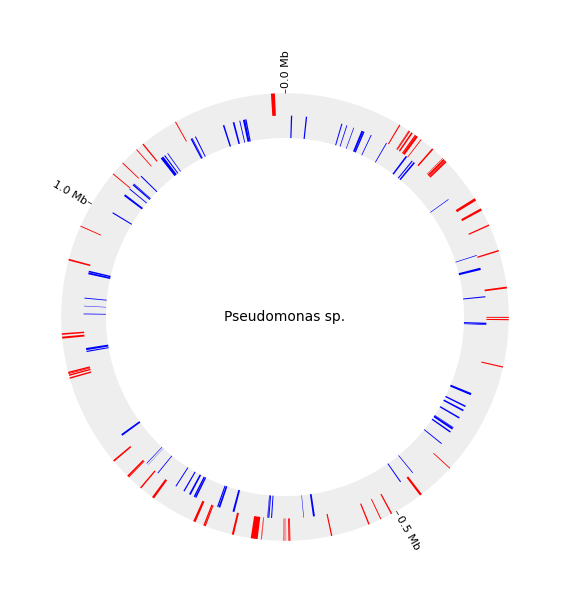

In [45]:
circos = Circos(sectors={accession: genome_length})
circos.text("Pseudomonas sp.")
circos_gff = Gff(gff_file="candidates.gff")
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" )
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue")
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=500000,
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",
    label_orientation="vertical")
fig = circos.plotfig().set_figwidth(5)

### En rojo vemos los genes que estan en la cadena positiva y en azul los genes que están en la cadena negativa. Sabemos que el genoma de *Pseudomonas* es circular y sus cromomosas están organizados en operones. A simple vista se puede observar que si vemos (aunque muy pocos) genes dan similitud contra las secuencias de Uniprot posiblemente tengan la función de síntesis de compuestos antimicrobianos

### 6.1.6 Visualización de los datos con seaborn

### Usaremos una serie de swarmplots en donde podemos comparar las posiciones de los genes en el dataframe completo, separando por categorias ("genes candidatos" vs "genes no candidatos") y por cadena ("+" vs "-")


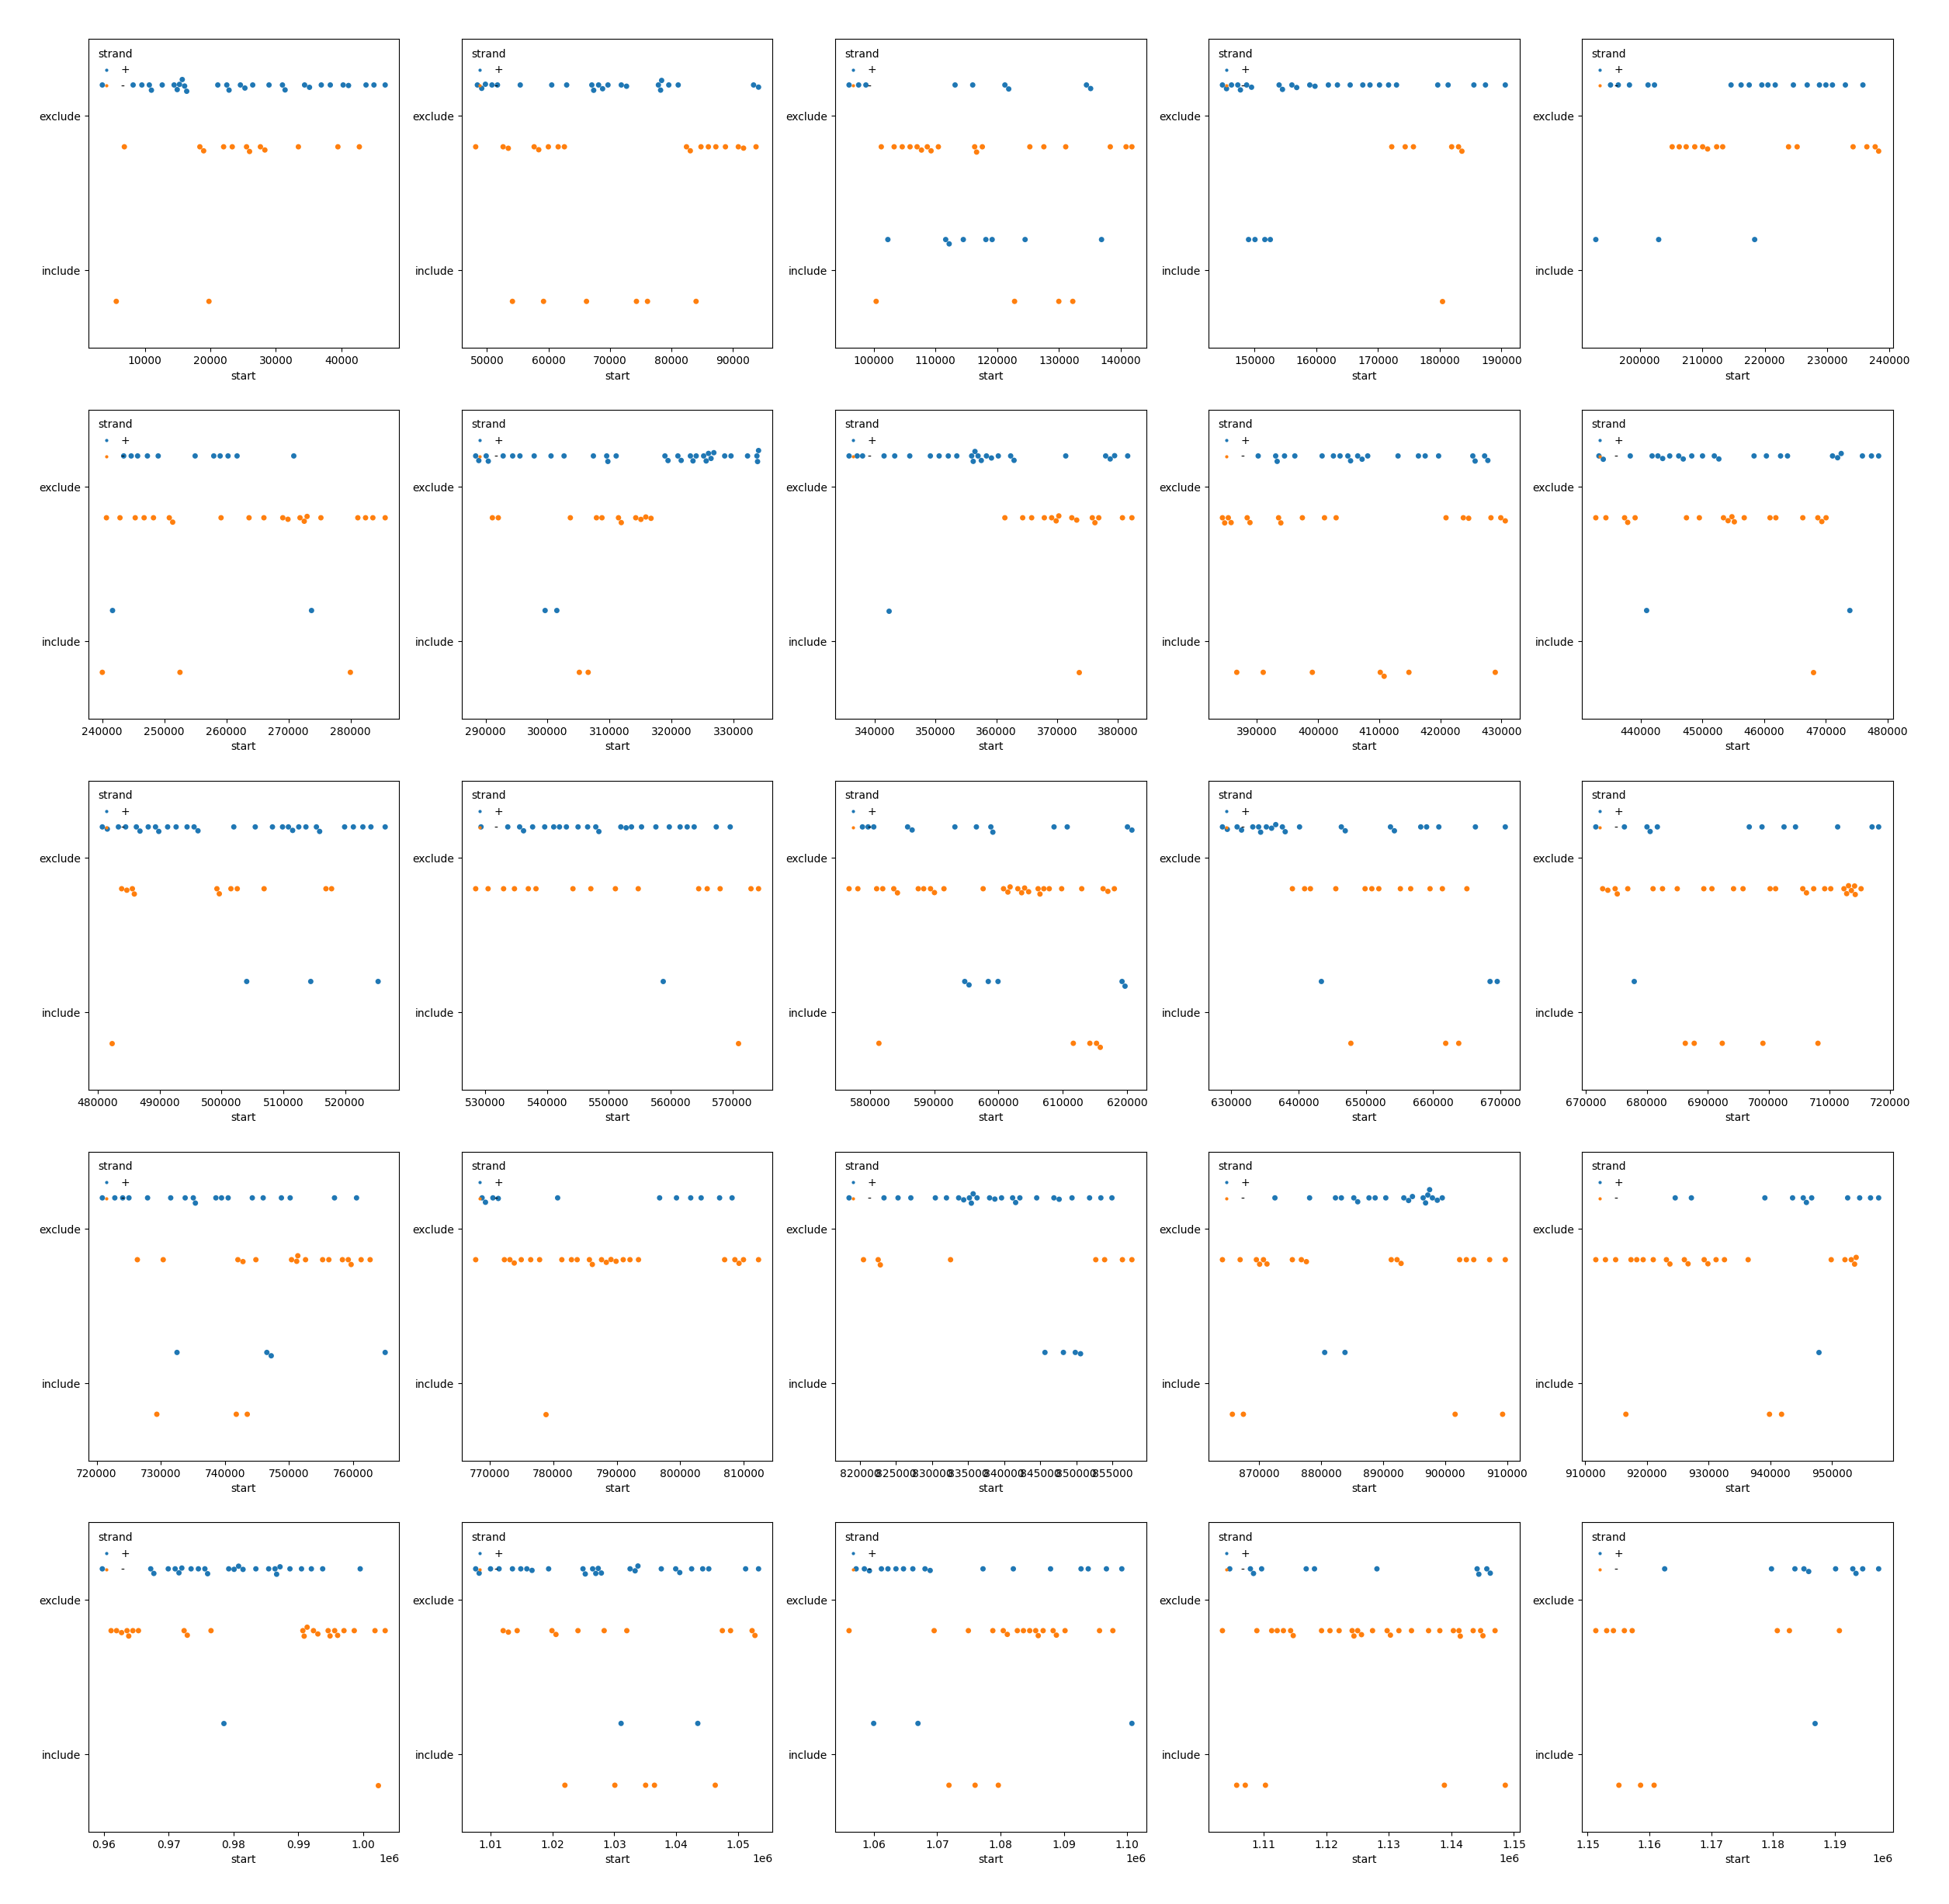

In [ ]:
num_bins = 25
counter_1 = 0
counter_2 = 0
fig, axes = plt.subplots(5,5,figsize=(30,30))
bin_len  = (genome_length - (genome_length % (num_bins - 1))) / (num_bins)
for bin_num in range(num_bins):
    start_pos = bin_num * bin_len
    end_pos   = (bin_num + 1) * bin_len
    mb_df = gff_df.copy()
    mb_df = mb_df[(mb_df["start"]>start_pos) & (mb_df["end"]<=end_pos)]
    sns.swarmplot(ax = axes[counter_1,counter_2],data = mb_df,y="candidate",x="start",hue="strand",dodge=True,order=["exclude","include"],hue_order=["+","-"])
    axes[counter_1,counter_2].set(ylabel=None)
    counter_2 += 1
    if (counter_2%5 == 0):
        counter_2 = 0
        counter_1 += 1
plt.show()

# **7. Examinación a detalle del operón seleccionado**

### Obtendremos información del operón que seleccionamos, en este ejemplo vemos que en entre las posiciones 0.61 Mb y 0.62 Mb  puede haber un operon que codifique para la síntesis de aminoácidos.
### Podemos analizar las secuencias aminoacídicas de los genes de dicha región a través del servicio de búsqueda de dominios conservados de InterProScan

### Lo primero que debemos hacer es obtener los IDs de los genes presentes en dicho operón

In [51]:
operon_df = gff_df.copy()
operon_df = operon_df[(operon_df["start"]     >= 610000) &
                      (operon_df["end"]       <= 620000) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]
operon_df.reset_index(drop=True, inplace=True)

In [52]:
operon_df


,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,PseudoDS1,pyrodigal_v2.1.0,CDS,611637,612623,45.0,-,0,ID=PseudoDS1_551;partial=00;start_type=ATG;rbs...,"{'ID': 'PseudoDS1_551', 'partial': '00', 'star...",include
1,PseudoDS1,pyrodigal_v2.1.0,CDS,614213,615217,199.4,-,0,ID=PseudoDS1_553;partial=00;start_type=ATG;rbs...,"{'ID': 'PseudoDS1_553', 'partial': '00', 'star...",include
2,PseudoDS1,pyrodigal_v2.1.0,CDS,615245,615751,109.9,-,0,ID=PseudoDS1_554;partial=00;start_type=ATG;rbs...,"{'ID': 'PseudoDS1_554', 'partial': '00', 'star...",include
3,PseudoDS1,pyrodigal_v2.1.0,CDS,615832,616269,81.3,-,0,ID=PseudoDS1_555;partial=00;start_type=ATG;rbs...,"{'ID': 'PseudoDS1_555', 'partial': '00', 'star...",include


In [53]:
len(operon_df)#tenemosun total de 4 genes

4

In [54]:
operon_gene_list = []
for index in operon_df.index.tolist():
    gene_id = operon_df["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)

    #obtendremos el identificador 

In [55]:
operon_gene_list#vemos que tienen numeros de acceso consecutivos, lo que puede indicar que forman parte de un operon

['PseudoDS1_551', 'PseudoDS1_553', 'PseudoDS1_554', 'PseudoDS1_555']

### Construiremos un *string* que contendrá las secuencias aminoacídicas de los genes de interés en formato fasta

### Este *string* lo enviaremos al servicio web de InterProScan para buscar dominios conservados en nuestras proteínas

> ### Antes de correr el servicio web, eliminaremos los asteriscos de las secuencias

In [48]:
query_str = ""

In [56]:
for record in SeqIO.parse(aa_file, "fasta"):
    seq_id  = record.id
    if(seq_id in operon_gene_list):
        seq_str = str(record.seq)
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

### En este ejemplo seguiremos el proceso suegerido de búsqueda de dominios y lo dividiremos en tres etapas:

- #### Envío de las secuencias
- #### Consulta del status del envío
- #### Descarga de resultados

### Cada etapa tiene una URL específica la cual definiremos a continuación

In [57]:
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

### De igual manera, cada etapa acepta headers específicos

In [58]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

## 7.1 Envío de las secuencias

### En esta etapa, construiremos un diccionario de python que adjuntaremos a `requests` para buscar los dominios funcionales

In [59]:
submit_data = {"email":"paulyna_9omar@hotmail.com",
               "title":"operon_335_345",
               "goterms":"false",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

### Y ya con los datos listos enviamos nuestra solicitud a InterProScan

In [60]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

### La API de InterProScan entrega un código de estado y un `job_id`.

> ### El código de salida del servidor web, nos indican si la solicitud fue exitosa:
>> * 1xx informational response – the request was received, continuing process
>>* 2xx successful – the request was successfully received, understood, and accepted
>> * 3xx redirection – further action needs to be taken in order to complete the request
>> * 4xx client error – the request contains bad syntax or cannot be fulfilled
>> * 5xx server error – the server failed to fulfil an apparently valid request

### El servidor nos entrega un código de estado 200, nuestras secuencias entraron en el servicio web

### Con el siguiente código podemos obtener tanto nuestro `job_id` como el código de estado

In [61]:
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text

In [62]:
print(submit_status_code)
print(submit_job_id)

200
iprscan5-R20230317-163852-0107-11750271-p2m


### Ya tenemos nuestro Job_id 

## 7.2 Progreso del análisis de las secuencias

### Con nuestro `job_id` podemos consultar el progreso del análisis con las siguientes líneas de código

In [64]:
progress_request     = requests.get(progress_url+"/"+submit_job_id,headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)

200
FINISHED


### Nuevamente, si el servidor nos entrega un código de estado 200, nuestra consulta fue exitosa y el rersultado es FINISHED

## 7.3 Obtención de los resultados

### Si el estado del análisis es "FINISHED", podemos consultar el resultado de nuestro análisis

- ### `log` para acceder al reporte de texto del programa
- ### `tsv` para acceder al reporte tabular programa

In [65]:
results_log_request = requests.get(results_url+"/"+submit_job_id+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+submit_job_id+"/tsv",headers=results_headers)

In [66]:
print(results_log_request.text)

17/03/2023 16:38:54:641 Welcome to InterProScan-5.61-93.0
17/03/2023 16:38:54:642 Running InterProScan v5 in STANDALONE mode... on Linux
17/03/2023 16:39:02:331 RunID: hx-wp-04-04.ebi.ac.uk_20230317_163902001_axx0
17/03/2023 16:39:15:486 Loading file /nfs/public/rw/es/projects/wp-jdispatcher/logs/prod/sources/jobs/iprscan5/rest/20230317/1638/iprscan5-R20230317-163852-0107-11750271-p2m.sequence
17/03/2023 16:39:15:489 Running the following analyses:
[AntiFam-7.0,CDD-3.20,Coils-2.2.1,FunFam-4.3.0,Gene3D-4.3.0,Hamap-2021_04,MobiDBLite-2.0,PANTHER-17.0,Pfam-35.0,Phobius-1.01,PIRSF-3.10,PIRSR-2021_05,PRINTS-42.0,ProSitePatterns-2022_05,ProSiteProfiles-2022_05,SFLD-4,SignalP_EUK-4.1,SignalP_GRAM_NEGATIVE-4.1,SignalP_GRAM_POSITIVE-4.1,SMART-9.0,SUPERFAMILY-1.75,TIGRFAM-15.0,TMHMM-2.0c]
Available matches will be retrieved from the pre-calculated match lookup service.

Matches for any sequences that are not represented in the lookup service will be calculated locally.
17/03/2023 16:39:29:929 25

## 7.4 Examinación de los datos de dominios conservados

### Finalmente, usaremos la biblioteca StringIO para incorporar nuestros resultados de `requests` en un nuevo dataframe

In [67]:
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)

In [68]:
results_df

,sequence,md5,length,database,accession,description,start,end,evalue,post_processed,date,entry,name
0,PseudoDS1_551,3e1e776371e1fd6c447957ef1fc88d2d,328,Pfam,PF14859,Colicin M,144,317,5.8E-41,T,17-03-2023,IPR028056,Colicin M
1,PseudoDS1_551,3e1e776371e1fd6c447957ef1fc88d2d,328,Gene3D,G3DSA:3.30.450.400,"Colicin M, catalytic domain",171,325,6.8E-50,T,17-03-2023,-,-
2,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PRINTS,PR00101,Aspartate carbamoyltransferase signature,55,77,2.8E-31,T,17-03-2023,-,-
3,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PRINTS,PR00101,Aspartate carbamoyltransferase signature,93,102,2.8E-31,T,17-03-2023,-,-
4,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PRINTS,PR00101,Aspartate carbamoyltransferase signature,150,167,2.8E-31,T,17-03-2023,-,-
5,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PRINTS,PR00101,Aspartate carbamoyltransferase signature,235,244,2.8E-31,T,17-03-2023,-,-
6,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PRINTS,PR00101,Aspartate carbamoyltransferase signature,276,281,2.8E-31,T,17-03-2023,-,-
7,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PRINTS,PR00101,Aspartate carbamoyltransferase signature,300,314,2.8E-31,T,17-03-2023,-,-
8,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,PANTHER,PTHR45753,"ORNITHINE CARBAMOYLTRANSFERASE, MITOCHONDRIAL",15,319,3.3E-63,T,17-03-2023,-,-
9,PseudoDS1_553,72b0d51e2cf052e5271ba27486c8e8e6,334,Pfam,PF02729,"Aspartate/ornithine carbamoyltransferase, carb...",19,163,1.2E-40,T,17-03-2023,IPR006132,"Aspartate/ornithine carbamoyltransferase, carb..."


### Con este DataFrame construído podemos ver los dominios conservados que posiblemente corresponden con una función específica de nuestras proteínas. 



## En este ejercicio empleamos diversas bibliotecas que nos permitieron:

- ### Descargar secuencias genómicas no anotadas de GenBank
- ### Predecir secuencias codificantes en dicho genoma
- ### Obtener secuencias de referencia de UniProt asociadas a una ruta metabólica o a un proceso molecular
- ### Comparar las secuencias de referencia contra nuestras predicciones para determinar si en nuestro genoma hay genes codificantes asociados a la ruta metabólica o proceso que especificamos en la búsqueda de secuencias de UniProt
- ### Visualizar los datos genómicos a nivel grueso (pyCirclize) y a nivel fino (seaborn)
- ### Filtrar nuestros resultados para analizar unicamente un subset de secuencias, potencialmente asociadas a la ruta metabólica o al proceso molecular de interés
- ### Búsqueda de dominios funcionales en el subset de proteínas de interés

# **8. Conclusión del ejercicio**


## En este ejercicio se empleó una secuencia génimica del género *Pseudomonas*, el cual, se ha investigado que producen metabolitos secundarios que son efectivos para uso en biocontrol (Bonaterra, et al. 2022).

### La secuencia elegida nos permitió realizar el ejercicio y encontrar proteínas asociadas a la síntesis de compuestos antimicrobianos
### Aunque de manera muy conspicua, se logró identificar un operón que codifica para la síntesis de amonoácidos de interés, en el cual pudimos identificar 4 genes.
### Finalmente pudimos hacer la búisqueda de dominios conservados que posiblemente corresponden con una función específica de las proteínas
